In [1]:
# vou assumir q a secao ja existe
import os
from legacy.atributos import Atributos
secao = Atributos(os.path.join('data/existe/CL3822_maior.sgy'), resolucao = 25, deltaz = [9955, 2000])
secao.extent = [1, secao.X.shape[0] * secao.resolucao, 9955, 2000]

# Carregue o dado de velocidade

In [1]:
import os
from ipyfilechooser import FileChooser
upload = FileChooser(os.getcwd() + '/data')
display(upload)

FileChooser(path='/home/remote/Documents/git/petrobras/petrobras-entrega/data', filename='', title='', show_hi…

# Backend

In [3]:
import segyio
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from legacy.atributos import Atributos
from legacy.utils import plot, concatenate, subplot

In [4]:
from scipy.ndimage import zoom

def resample(obj):
    crop_vel(obj)
    zoom_factors = (
        obj.X.shape[0] / obj.velocidade.shape[0],
        obj.X.shape[1] / obj.velocidade.shape[1]
    )
    obj.velocidade_rs = zoom(obj.velocidade, zoom_factors, order=3)

def crop_vel(obj):
    extent = [2000, 9955]
    h = int(obj.velocidade.shape[1] * extent[0] / extent[1])
    obj.velocidade = obj.velocidade[:, h:]

In [5]:
secao.velocidade = segyio.tools.cube(upload.value)[0, :, :]
resample(secao)

In [6]:
secao._complexo()
secao._soterramento(marambaia = False)

In [7]:
k = 100
obj = secao

scaler = StandardScaler()
Z = scaler.fit_transform(concatenate([obj.velocidade_rs]))
pca = PCA()
H = pca.fit_transform(Z)

kmeans = KMeans(n_clusters = k, n_init = 'auto', random_state = 0).fit(H)
clusters = kmeans.labels_
clusters = clusters.reshape(obj.X.shape)

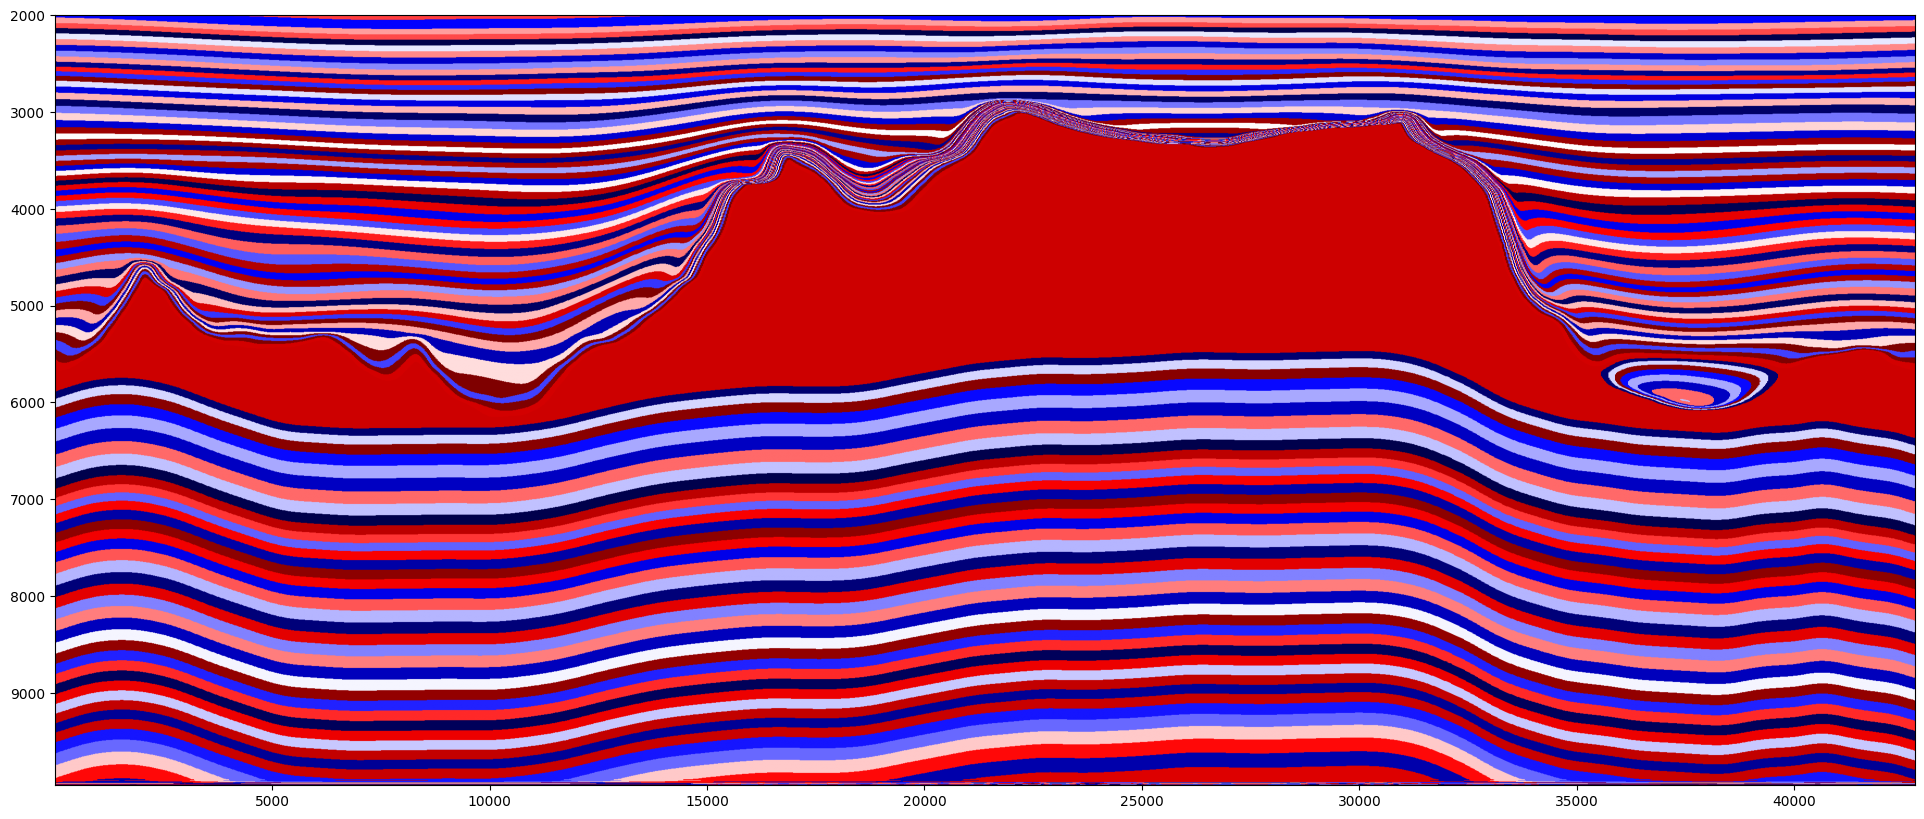

In [8]:
plot(obj, clusters)

In [9]:
unique, counts = np.unique(clusters, return_counts = True)
sal = unique[np.argmax(counts)]

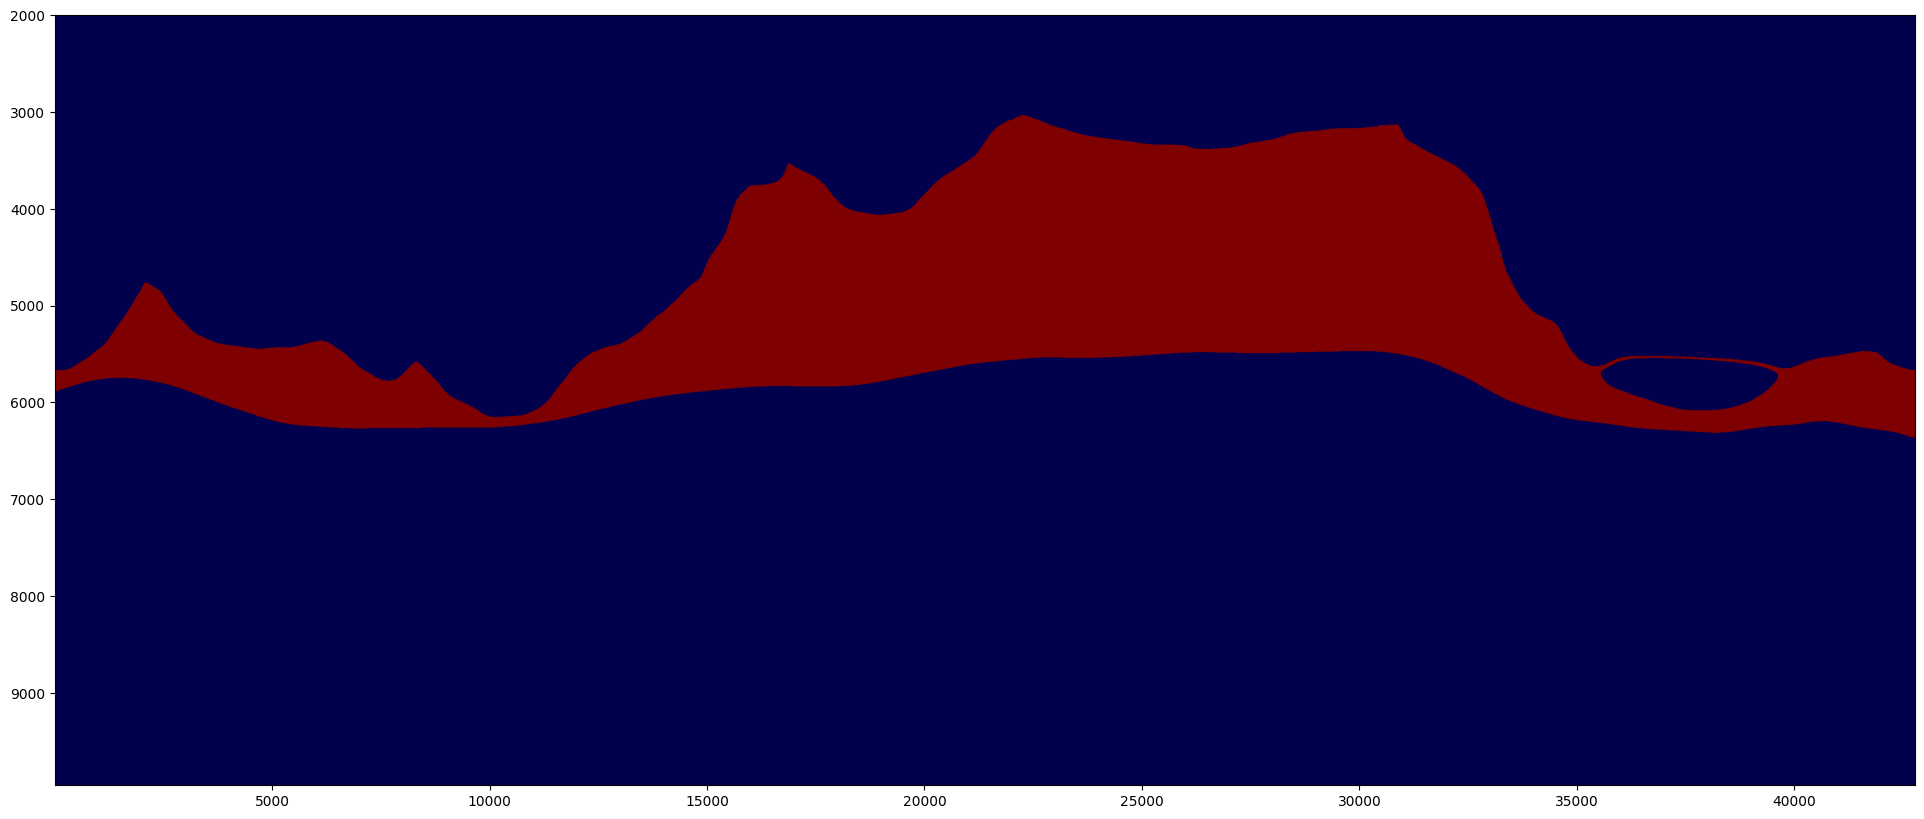

In [10]:
plot(obj, 1*(clusters==sal))

In [11]:
obj.partial = np.copy(obj.velocidade_rs)
for j in range(obj.partial.shape[0]):
    last = np.where(clusters[j, :] == sal)[0][-1]
    obj.partial[j, :last] = 0

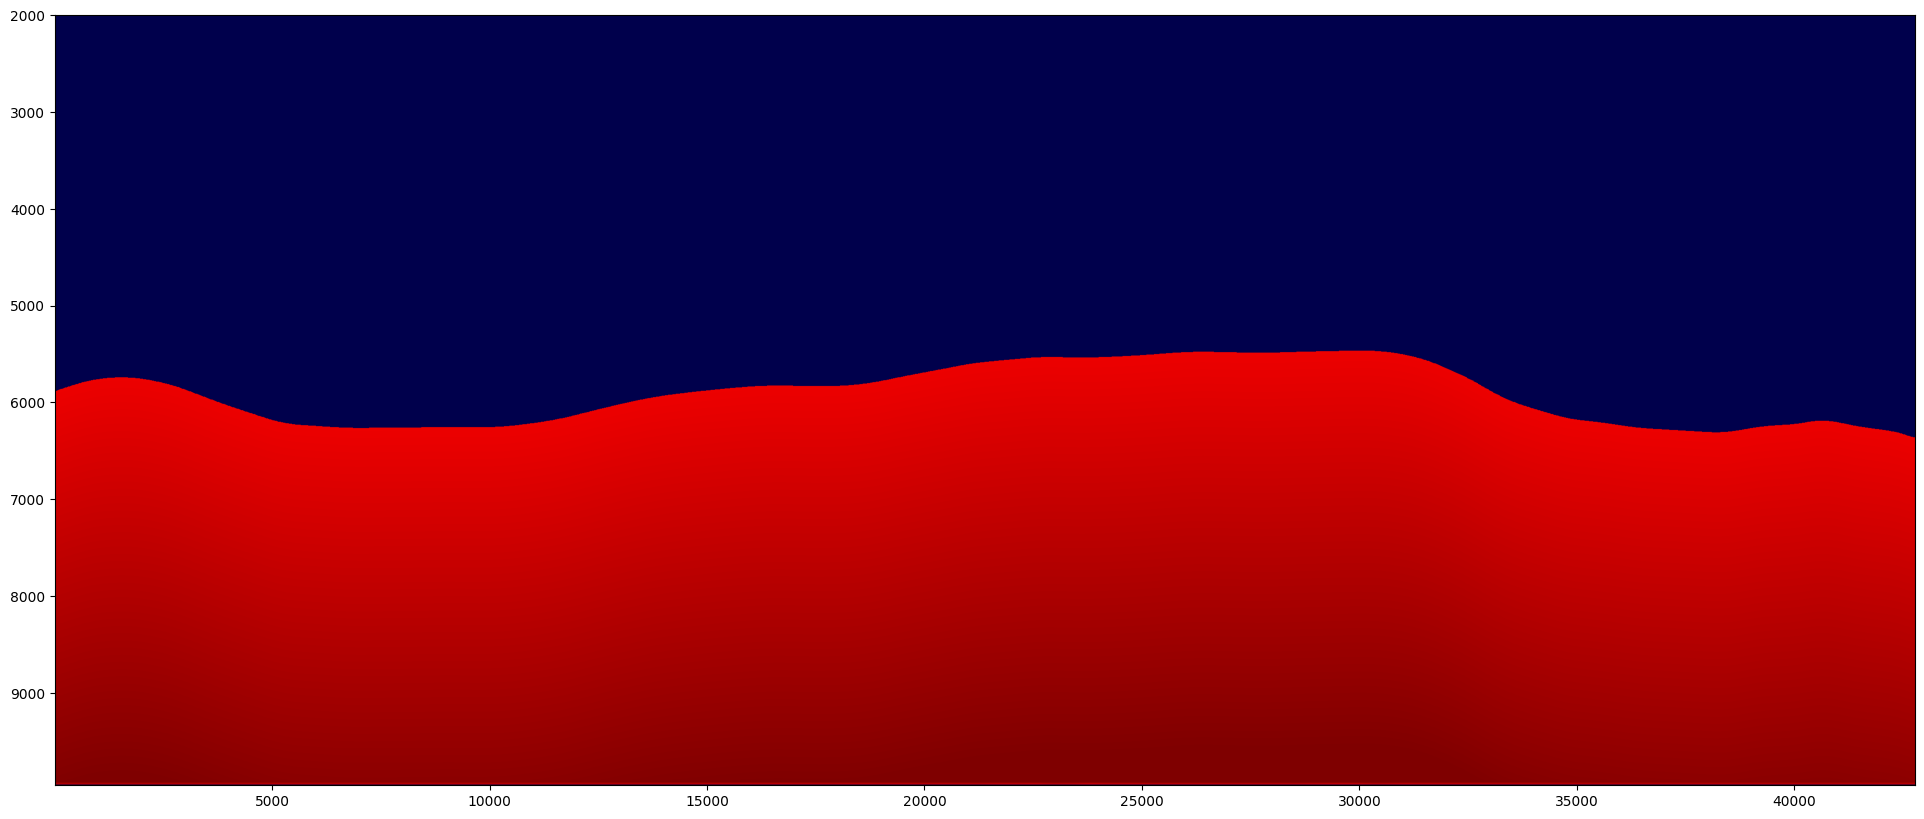

In [12]:
plot(obj, obj.partial)

In [13]:
obj.partialyy = np.copy(obj.yy)
for j in range(obj.partialyy.shape[0]):
    last = np.where(clusters[j, :] == sal)[0][-1]
    obj.partialyy[j, :last] = 0

obj.partialfs = np.copy(obj.fase)
for j in range(obj.partialfs.shape[0]):
    last = np.where(clusters[j, :] == sal)[0][-1]
    obj.partialfs[j, :last] = 0

In [14]:
def mistura(obj):
    return [
        # obj.partialfs, 
        # obj.partialyy, # soterramento
        # obj.velocidade_rs, # velocidade
        obj.partial, # velocidade
        ]

In [15]:
k = 4

scaler = StandardScaler()
# Z = scaler.fit_transform(concatenate([obj.partial]))
Z = scaler.fit_transform(concatenate(mistura(obj)))
pca = PCA()
H = pca.fit_transform(Z)

kmeans = KMeans(n_clusters = k, n_init = 'auto', random_state = 0).fit(H)
clusters = kmeans.labels_

clusters = clusters.reshape(obj.X.shape)

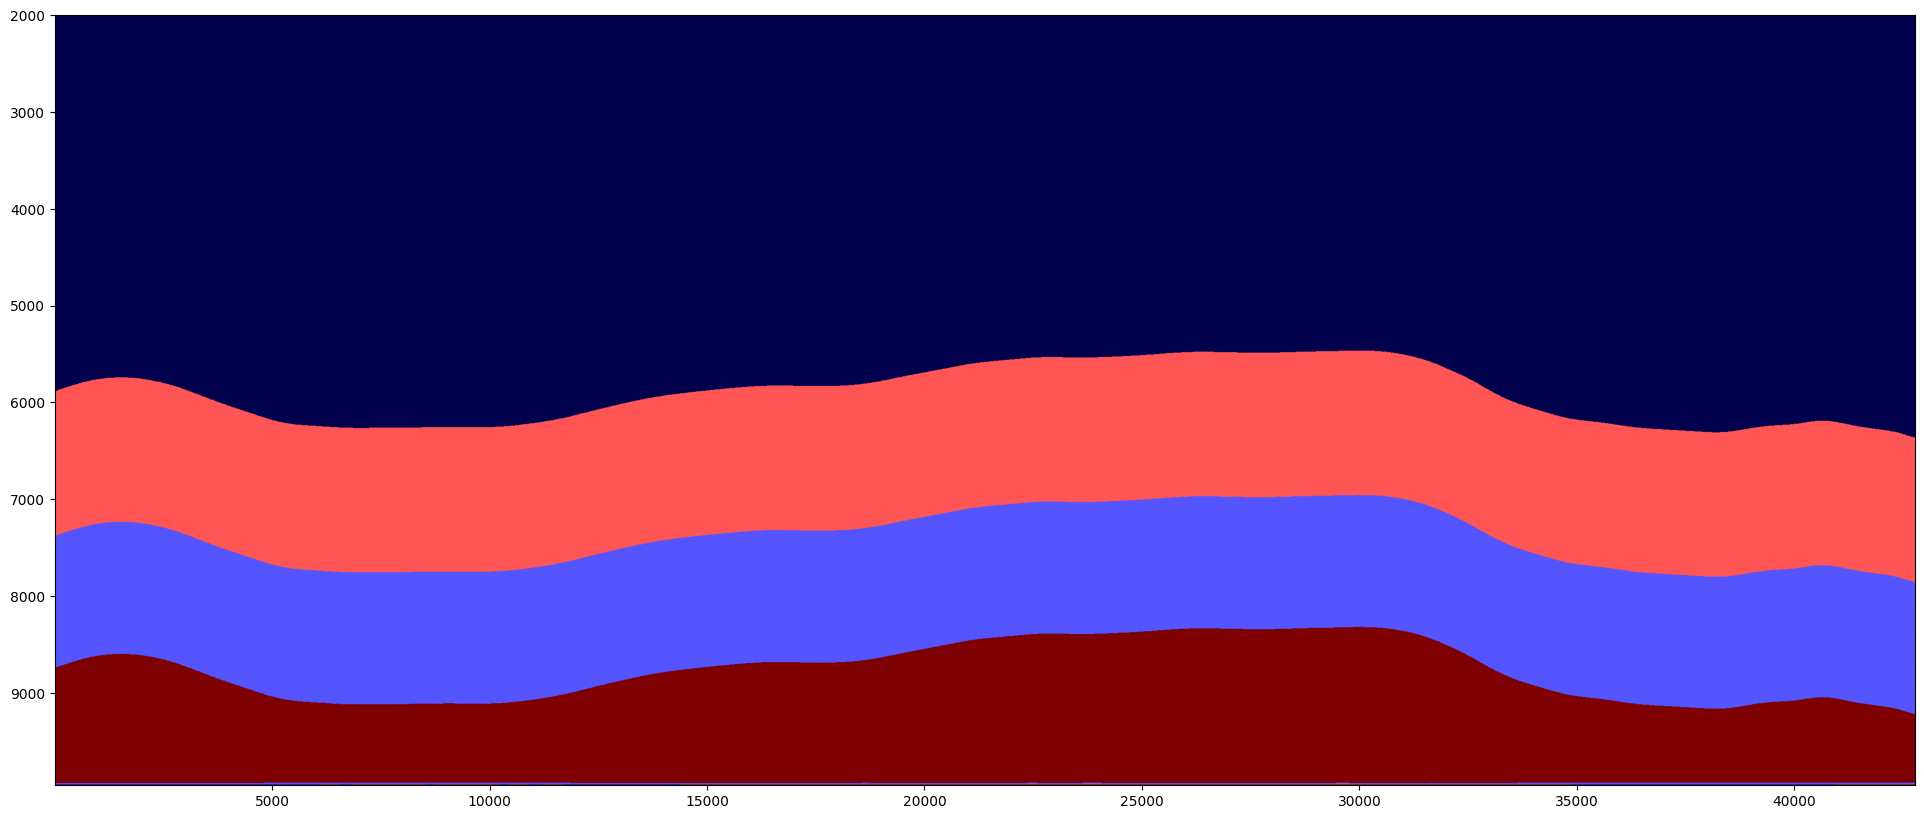

In [16]:
plot(obj, clusters)

In [17]:
unique, counts = np.unique(clusters, return_counts = True)
sal = unique[np.argmax(counts)]

presal = []
for i in range(clusters.shape[0]):
    first = np.where(np.diff(clusters[i, :]) != 0)[0][0] + 1
    presal.append(clusters[i, first])
unique2, counts2 = np.unique(presal, return_counts = True)
presal = unique2[np.argmax(counts2)]

obj.yhat = 1*(clusters == presal)

# Resultado

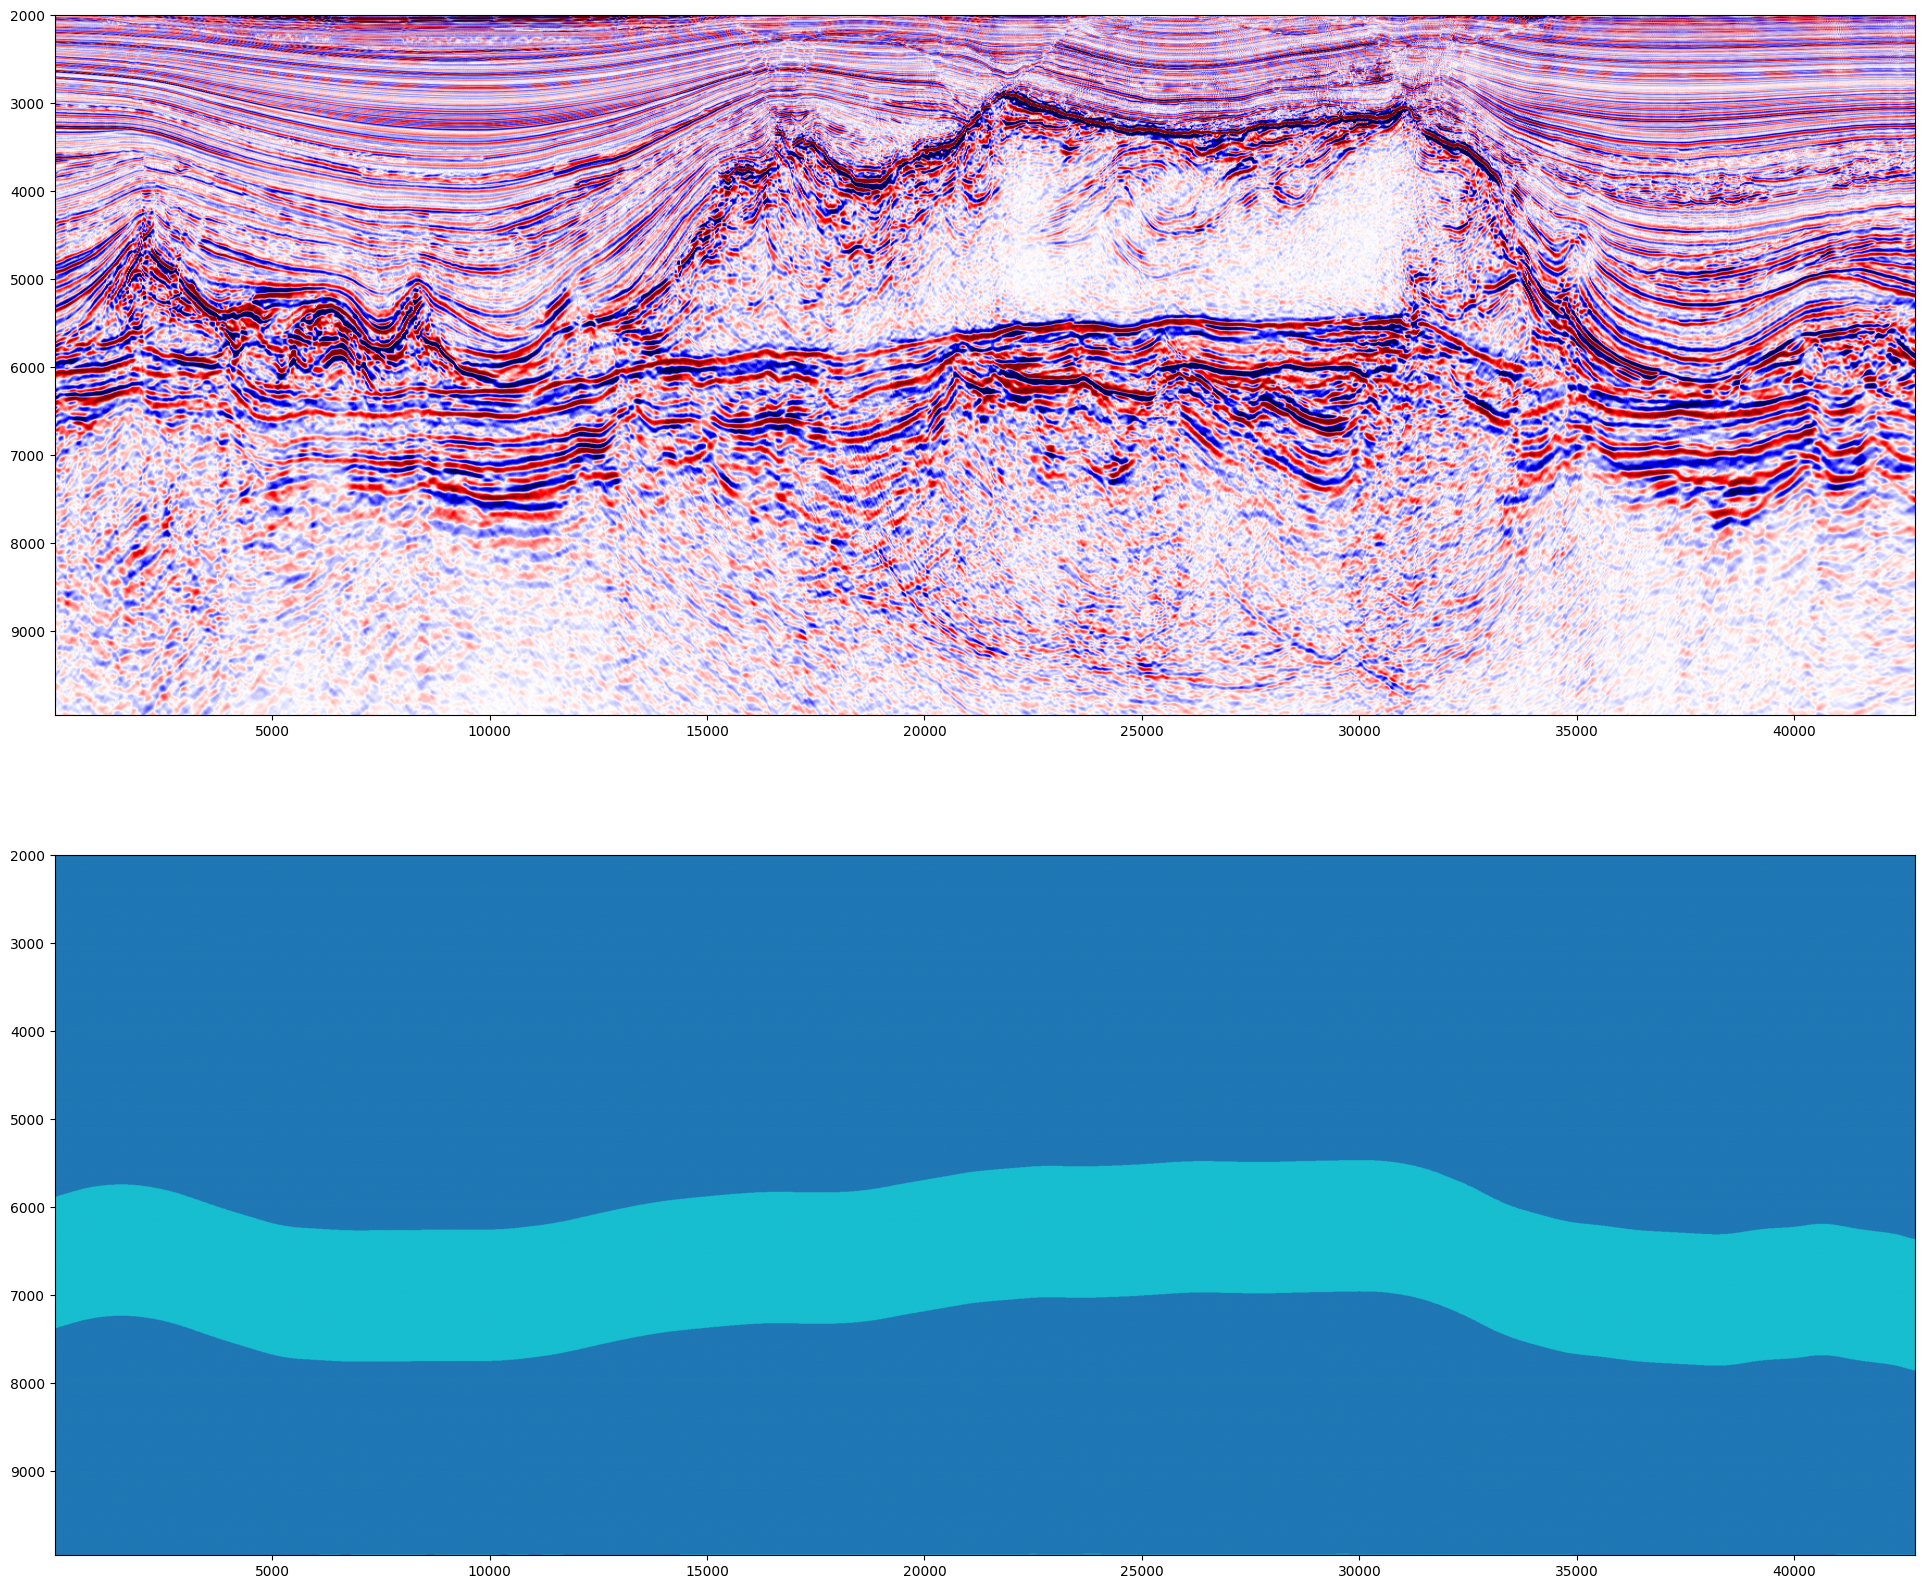

In [18]:
subplot(secao, [secao.X, secao.yhat], colors = ['seismic', 'tab10'], percentils = [(1, 99), (0, 100)])

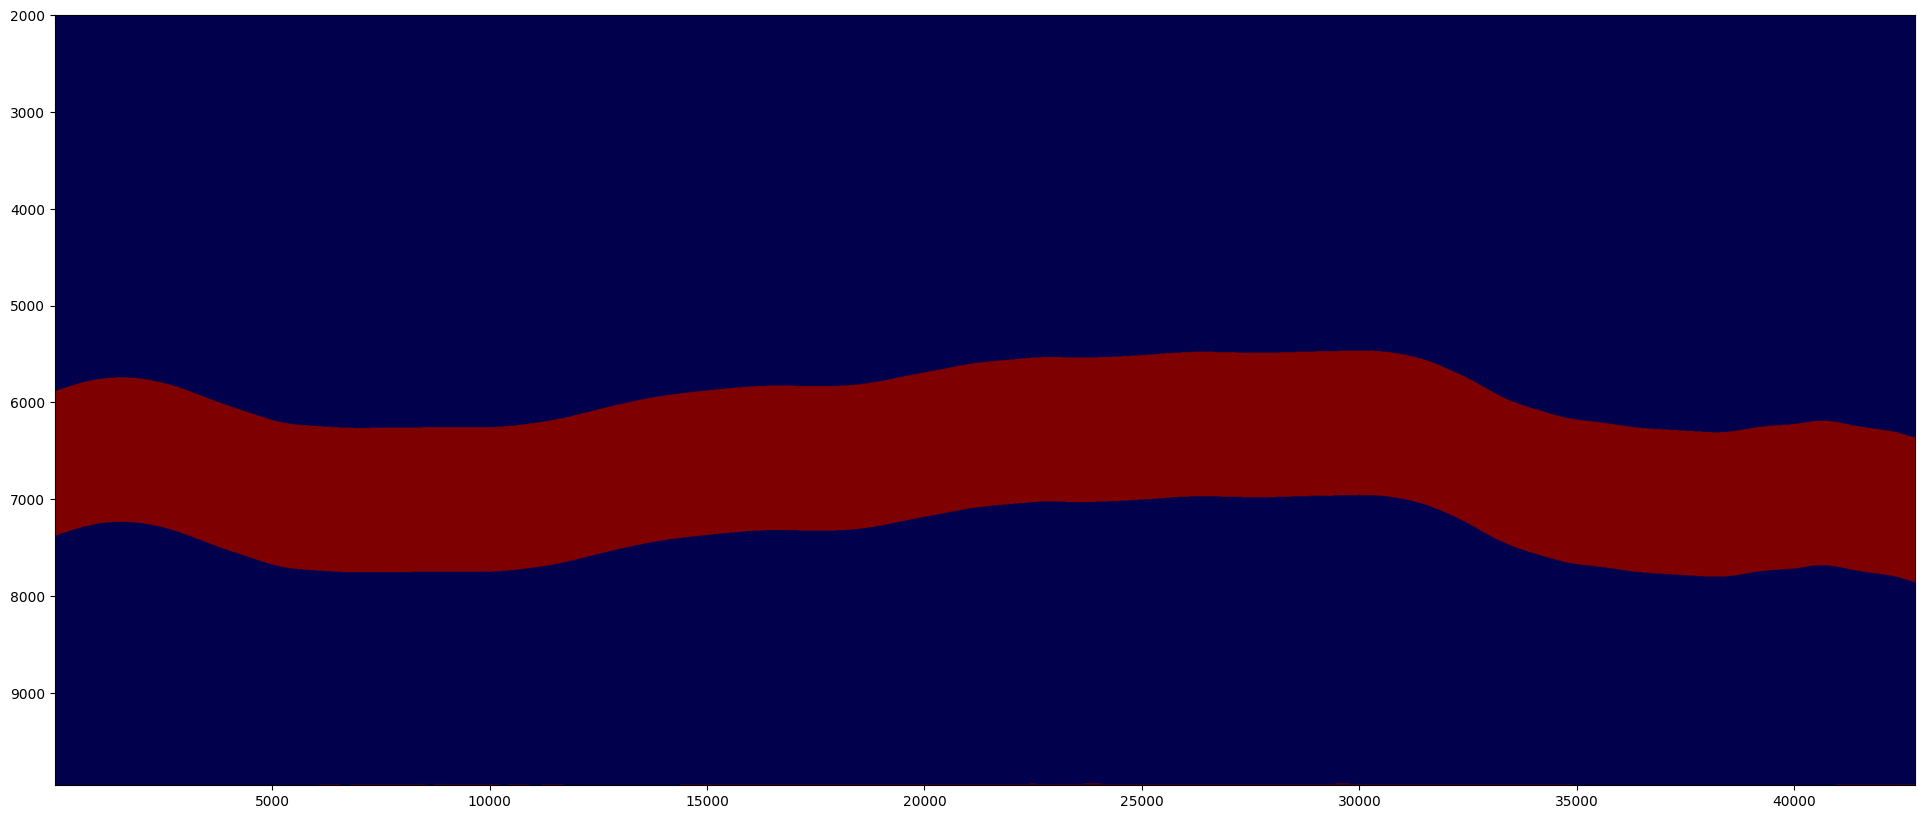

In [19]:
plot(secao, secao.yhat)